In [ ]:
import pandas as pd

# Load the dataset
labeled_df = pd.read_csv("data/new_labeled_dataset.csv")

# Preview
print(labeled_df.head())
print(labeled_df.columns)  # See available columns


                                            sentence  \
0  YouTube is making clear there will be no “birt...   
1  The increasingly bitter dispute between Americ...   
2  So while there may be a humanitarian crisis dr...   
3  A professor who teaches climate change classes...   
4  Looking around the United States, there is nev...   

                                           news_link      outlet  \
0  https://eu.usatoday.com/story/tech/2020/02/03/...   usa-today   
1  https://www.nbcnews.com/news/sports/women-s-te...       msnbc   
2  https://www.alternet.org/2019/01/here-are-5-of...    alternet   
3  https://www.breitbart.com/politics/2019/05/09/...   breitbart   
4  https://thefederalist.com/2020/03/11/woman-who...  federalist   

            topic    type  group_id  num_sent  Label_bias  \
0  elections-2020  center         1         1      Biased   
1           sport    left         1         1  Non-biased   
2     immigration    left         1         1      Biased   
3     envi

In [ ]:
# Text Libraries
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


In [3]:
# Machine Learning Libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [ ]:
# Make a copy of the original dataset
df = labeled_df.copy()

## Recode label_bias variable
# Drop rows where label_bias is 'no-agreement'
df = df[df["Label_bias"].isin(["Biased", "Non-biased"])]

# Map to binary
df["Label_bias_binary"] = df["Label_bias"].map({"Biased": 1, "Non-biased": 0})

print(df["Label_bias_binary"].value_counts())


Label_bias_binary
1    1018
0     533
Name: count, dtype: int64


In [ ]:
## Create a new variable: n_biased_words
# Turn strings into lists
import ast

if isinstance(df["biased_words4"].iloc[0], str):
    df["biased_words4"] = df["biased_words4"].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else []
    )

# Remove stopwords
stopword = stopwords.words("english")
df["biased_words"] = df["biased_words4"].apply(
    lambda wordlist: [w for w in wordlist if w.lower() not in stopword]
)

# Calculate the # of biased words for each sentence
df["n_biased_words"] = df["biased_words"].apply(len)


In [ ]:
## Text cleaning & preprocessing
# regular expression to identify non-ascii characters
non_ascii_regex = r"[^\x00-\x7F]+"


def tokenize(text):
    text = re.sub(non_ascii_regex, " ", text)  # Remove non-ASCII
    text = text.lower()  # Lowercase for consistency
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  # Remove punctuation
    tokens = text.split()  # Split on whitespace
    clean_tokens = [w for w in tokens if w not in stopword]
    return clean_tokens


# Test using an example sentence
sample = "Hello! This is a test sentence: Let's see how it handles punctuation, emojis 😊, and stopwords."
print(tokenize(sample))


['hello', 'test', 'sentence', 'let', 'see', 'handles', 'punctuation', 'emojis', 'stopwords']


In [ ]:
## Create new text statistics columns
# Calculate number of words in each sentence
df["sentence_word_count"] = df["sentence"].apply(lambda x: len(tokenize(x)))


# Calculate average word length in each sentence
def avg_word_length(tokens):
    if len(tokens) == 0:
        return 0
    return np.mean([len(w) for w in tokens])


df["avg_word_length"] = df["sentence"].apply(lambda x: avg_word_length(tokenize(x)))

# Unique word count
df["unique_word_count"] = df["sentence"].apply(lambda x: len(set(tokenize(x))))


In [ ]:
print(df.columns)


Index(['sentence', 'news_link', 'outlet', 'topic', 'type', 'group_id',
       'num_sent', 'Label_bias', 'Label_opinion', 'article', 'biased_words4',
       'merge_domain', 'factual_reporting', 'reliability_label',
       'Label_bias_binary', 'biased_words', 'n_biased_words',
       'sentence_word_count', 'avg_word_length', 'unique_word_count'],
      dtype='object')


In [ ]:
# Select features and the target variable
features = [
    "sentence",
    "num_sent",
    "n_biased_words",
    "sentence_word_count",
    "avg_word_length",
    "unique_word_count",
    "outlet",
    "topic",
    "type",
    "factual_reporting",
    "reliability_label",
]
target = "Label_bias_binary"

X = df[features]
y = df[target]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,  # stratify keeps class balance!
)


In [ ]:
# List categorical & numerical variables
categ_cols = ["outlet", "topic", "type", "factual_reporting"]
num_cols = [
    "num_sent",
    "n_biased_words",
    "sentence_word_count",
    "avg_word_length",
    "unique_word_count",
    "reliability_label",
]

# Text transformer with the tokenize function
text_transformer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=None,
    token_pattern=None,
    ngram_range=(1, 2),
    max_features=1000,
)
cat_transformer = OneHotEncoder()
num_transformer = StandardScaler()

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, "sentence"),
        ("cat", cat_transformer, categ_cols),
        ("num", num_transformer, num_cols),
    ]
)


In [ ]:
from sklearn.linear_model import LogisticRegression

# Create the pipeline and train the model
log_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced")),
    ]
)


In [ ]:
from sklearn.metrics import classification_report

# Fit and evaluate
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.65      0.81      0.72       107
           1       0.89      0.77      0.82       204

    accuracy                           0.78       311
   macro avg       0.77      0.79      0.77       311
weighted avg       0.81      0.78      0.79       311



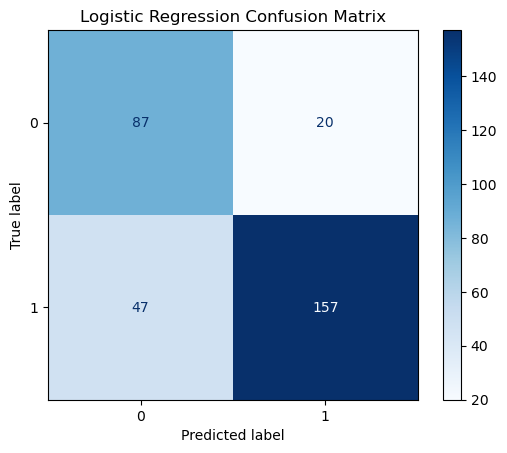

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


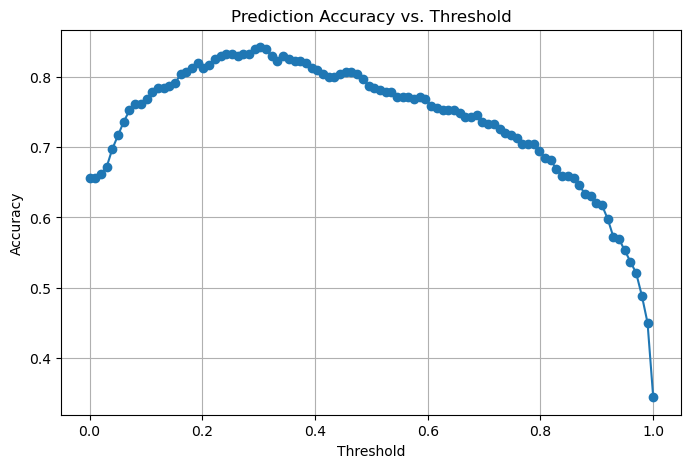

In [ ]:
## Now see how the accuracy changes with the threshold
from sklearn.metrics import accuracy_score

# Get predicted probabilities for class 1
y_probs = log_reg.predict_proba(X_test)[:, 1]

# Create a range of thresholds to test
thresholds = np.linspace(0, 1, 100)
accuracies = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plot accuracy vs. threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, accuracies, marker="o")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Prediction Accuracy vs. Threshold")
plt.grid(True)
plt.show()


              precision    recall  f1-score   support

           0       0.84      0.65      0.74       107
           1       0.84      0.94      0.88       204

    accuracy                           0.84       311
   macro avg       0.84      0.80      0.81       311
weighted avg       0.84      0.84      0.83       311



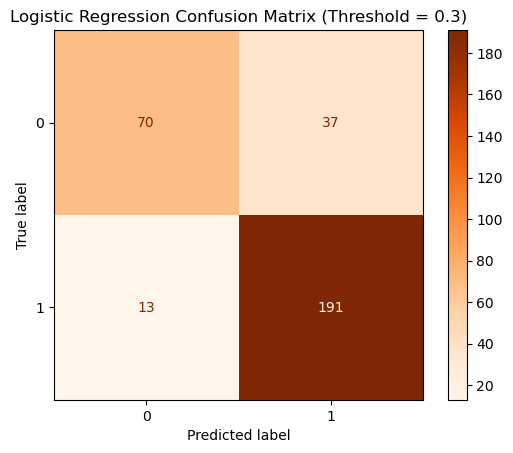

In [ ]:
## Try adjusting the threshold
threshold = 0.3
y_pred_custom = (y_probs >= threshold).astype(int)

# Evaluate performance with new threshold
print(classification_report(y_test, y_pred_custom))

# Confusion matrix for custom threshold
cm_custom = confusion_matrix(y_test, y_pred_custom)
disp_custom = ConfusionMatrixDisplay(
    confusion_matrix=cm_custom, display_labels=log_reg.classes_
)
disp_custom.plot(cmap="Oranges")
plt.title(f"Logistic Regression Confusion Matrix (Threshold = {threshold})")
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Set up the pipeline
rf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            RandomForestClassifier(
                n_estimators=500,  # number of trees, can tune
                min_samples_leaf=5,
                max_depth=None,  # no max depth, can tune
                class_weight="balanced",  # helps if classes are imbalanced
                random_state=42,
            ),
        ),
    ]
)


              precision    recall  f1-score   support

           0       0.66      0.73      0.69       107
           1       0.85      0.80      0.82       204

    accuracy                           0.77       311
   macro avg       0.75      0.76      0.76       311
weighted avg       0.78      0.77      0.78       311



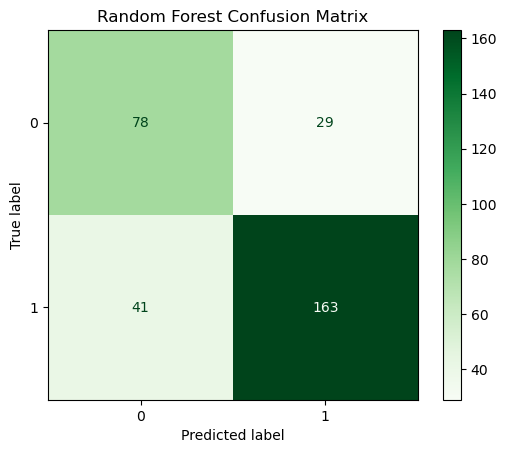

In [ ]:
# Fit the random forest pipeline
rf.fit(X_train, y_train)

# Predict on the test set
y_rf_pred = rf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_rf_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_rf_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=rf.named_steps["classifier"].classes_
)
disp.plot(cmap="Greens")
plt.title(f"Random Forest Confusion Matrix")
plt.show()


In [ ]:
## Feature importance
# Get preprocessed feature names
text_features = preprocessor.named_transformers_["text"].get_feature_names_out()
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categ_cols)
num_features = num_cols
all_features = np.concatenate([text_features, cat_features, num_features])

rf_feature_importance = pd.DataFrame(
    {
        "feature": all_features,
        "importance": rf.named_steps["classifier"].feature_importances_,
    }
)
rf_feature_importance = rf_feature_importance.sort_values("importance", ascending=False)

print(rf_feature_importance.head(20))


                      feature  importance
1028           n_biased_words    0.243494
1022              type_center    0.050351
1002        outlet_federalist    0.039184
1000          outlet_alternet    0.038563
906                     trump    0.028905
1007         outlet_usa-today    0.027199
1006           outlet_reuters    0.022565
760                      said    0.022196
1030          avg_word_length    0.021648
1026  factual_reporting_mixed    0.020990
1025   factual_reporting_high    0.020162
1023                type_left    0.018679
1032        reliability_label    0.017802
1031        unique_word_count    0.016114
1029      sentence_word_count    0.015687
1027                 num_sent    0.013657
1017              topic_sport    0.011518
1005             outlet_msnbc    0.011495
1024               type_right    0.008857
489                      like    0.008784


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier  # You may need: pip install xgboost


In [ ]:
## Model comparison & selection
# Define each model's pipeline
models = {
    "Logistic Regression": log_reg,
    "SVM": Pipeline(
        [
            ("preprocessor", preprocessor),
            ("classifier", LinearSVC(class_weight="balanced")),
        ]
    ),
    "KNN": Pipeline(
        [
            ("preprocessor", preprocessor),
            (
                "classifier",
                KNeighborsClassifier(n_neighbors=5),
            ),  # you can tune n_neighbors
        ]
    ),
    "Random Forest": rf,
    "XGBoost": Pipeline(
        [
            ("preprocessor", preprocessor),
            (
                "classifier",
                XGBClassifier(
                    eval_metric="logloss",
                    random_state=42,
                    scale_pos_weight=len(y_train[y_train == 0])
                    / len(y_train[y_train == 1]),
                ),
            ),
        ]
    ),
}


In [ ]:
## Cross-validation using accuracy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    acc_results[name] = scores
    print(f"{name} - Accuracy scores: {scores}")
    print(f"{name} - Mean: {np.mean(scores):.3f}, Std: {np.std(scores):.3f}")


Logistic Regression - Accuracy scores: [0.81854839 0.7983871  0.79435484 0.81048387 0.81048387]
Logistic Regression - Mean: 0.806, Std: 0.009
SVM - Accuracy scores: [0.79435484 0.79032258 0.80645161 0.78629032 0.80645161]
SVM - Mean: 0.797, Std: 0.008
KNN - Accuracy scores: [0.77016129 0.74596774 0.75       0.80241935 0.78225806]
KNN - Mean: 0.770, Std: 0.021
Random Forest - Accuracy scores: [0.81048387 0.79032258 0.79032258 0.80241935 0.79435484]
Random Forest - Mean: 0.798, Std: 0.008
XGBoost - Accuracy scores: [0.81451613 0.80645161 0.8266129  0.7983871  0.81048387]
XGBoost - Mean: 0.811, Std: 0.009


/var/folders/rm/6mtj7p8d2fz8qhs9gm648gm80000gn/T/ipykernel_7131/1347390719.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(acc_results.values(), labels=acc_results.keys())


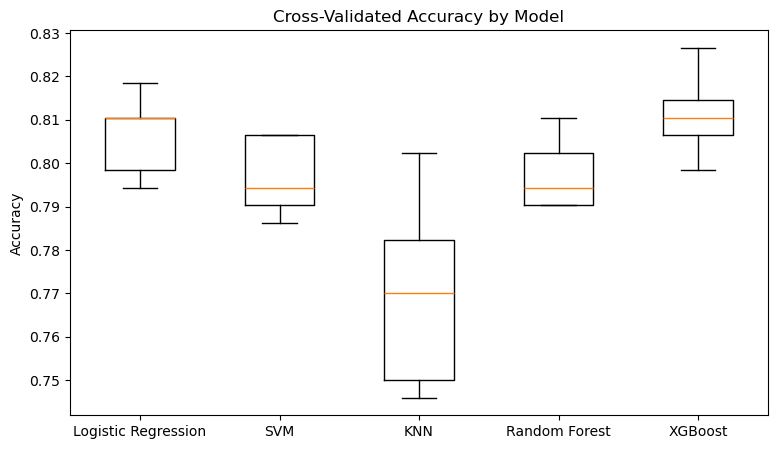

In [ ]:
plt.figure(figsize=(9, 5))
plt.boxplot(acc_results.values(), labels=acc_results.keys())
plt.ylabel("Accuracy")
plt.title("Cross-Validated Accuracy by Model")
plt.show()


In [ ]:
## Cross-validation using F1 scores
from sklearn.metrics import make_scorer, f1_score

f1_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")
    f1_results[name] = scores
    print(f"{name} - {'f1'} scores: {scores}")
    print(f"{name} - Mean: {np.mean(scores):.3f}, Std: {np.std(scores):.3f}")


Logistic Regression - f1 scores: [0.85804416 0.83870968 0.8411215  0.84280936 0.84984026]
Logistic Regression - Mean: 0.846, Std: 0.007
SVM - f1 scores: [0.84307692 0.83950617 0.85628743 0.83067093 0.85365854]
SVM - Mean: 0.845, Std: 0.009
KNN - f1 scores: [0.83381924 0.80966767 0.81547619 0.85106383 0.83435583]
KNN - Mean: 0.829, Std: 0.015
Random Forest - f1 scores: [0.85538462 0.83850932 0.8404908  0.84345048 0.83601286]
Random Forest - Mean: 0.843, Std: 0.007
XGBoost - f1 scores: [0.85889571 0.85185185 0.87240356 0.8427673  0.85626911]
XGBoost - Mean: 0.856, Std: 0.010


/var/folders/rm/6mtj7p8d2fz8qhs9gm648gm80000gn/T/ipykernel_7131/1406432439.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(f1_results.values(), labels=f1_results.keys())


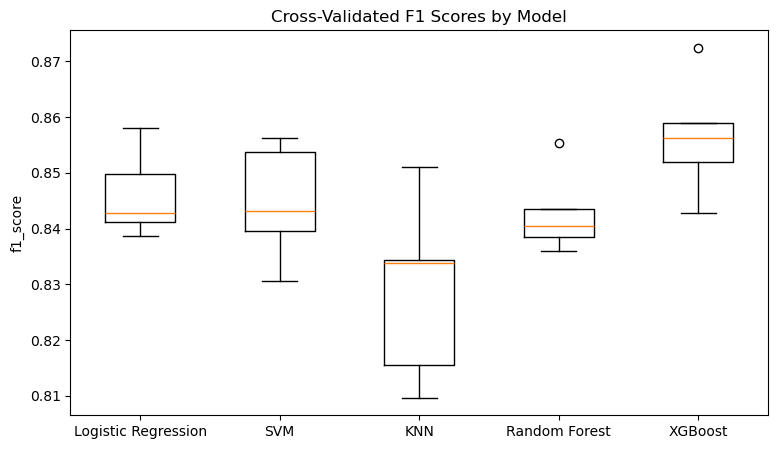

In [ ]:
# Visualize results
plt.figure(figsize=(9, 5))
plt.boxplot(f1_results.values(), labels=f1_results.keys())
plt.title(f"Cross-Validated F1 Scores by Model")
plt.ylabel("f1_score")
plt.show()


In [ ]:
## XG Boost as the best-fitting model

xgb = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            XGBClassifier(
                eval_metric="logloss",
                random_state=42,
                scale_pos_weight=len(y_train[y_train == 0])
                / len(y_train[y_train == 1]),
            ),
        ),
    ]
)

xgb.fit(X_train, y_train)


# Hyperparamter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__n_estimators": [100, 150, 200],
    "classifier__max_depth": [3, 5, 7],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__subsample": [0.8, 1.0],
}

gs = GridSearchCV(xgb, param_grid, scoring="f1", cv=3)
gs.fit(X_train, y_train)

print("Best parameters:", gs.best_params_)
print("Best cross-validated F1 score:", gs.best_score_)


Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
Best cross-validated F1 score: 0.8592509310659827


In [ ]:
# Recreate the model pipeline with best parameters
final_xgb = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            XGBClassifier(
                learning_rate=0.1,
                max_depth=3,
                n_estimators=100,
                subsample=1.0,
                eval_metric="logloss",
                random_state=42,
                scale_pos_weight=len(y_train[y_train == 0])
                / len(y_train[y_train == 1]),
            ),
        ),
    ]
)

# Fit on the full training set
final_xgb.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=1000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  token_pattern=None,
                                                                  tokenizer=<function tokenize at 0x15a6c49a0>),
                                                  'sentence'),
                                                 ('cat', OneHotEncoder(),
                                                  ['outlet', 'topic', 'type',
                                                   'factual_reporting']),
                                                 ('num', StandardScaler(),
                                                  ['num_sent', 'n_biased_words',
                                                   'sentence_word_count',
                                                   'avg_wo...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

              precision    recall  f1-score   support

           0       0.68      0.77      0.72       107
           1       0.87      0.81      0.84       204

    accuracy                           0.80       311
   macro avg       0.78      0.79      0.78       311
weighted avg       0.81      0.80      0.80       311



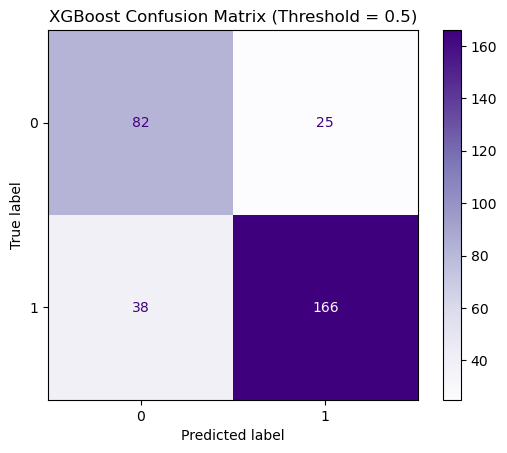

In [ ]:
# Predict and evaluate on the test set
y_pred = final_xgb.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=final_xgb.named_steps["classifier"].classes_
)
disp.plot(cmap="Purples")
plt.title("XGBoost Confusion Matrix (Threshold = 0.5)")
plt.show()


              precision    recall  f1-score   support

           0       0.73      0.65      0.69       107
           1       0.83      0.87      0.85       204

    accuracy                           0.80       311
   macro avg       0.78      0.76      0.77       311
weighted avg       0.79      0.80      0.79       311



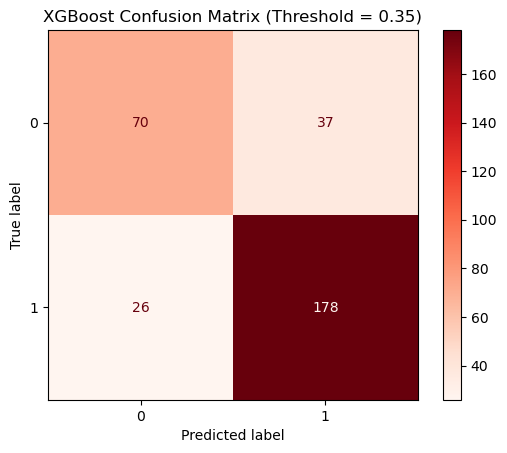

In [ ]:
# Lower the threshold to catch more biased sentences
threshold = 0.35

# Get predicted probabilities for the positive class
y_probs = xgb.predict_proba(X_test)[:, 1]
y_pred_custom = (y_probs >= threshold).astype(int)

# Evaluate at custom threshold
print(classification_report(y_test, y_pred_custom))

# Plot confusion matrix for custom threshold
cm_custom = confusion_matrix(y_test, y_pred_custom)
disp_custom = ConfusionMatrixDisplay(
    confusion_matrix=cm_custom, display_labels=xgb.named_steps["classifier"].classes_
)
disp_custom.plot(cmap="Reds")
plt.title(f"XGBoost Confusion Matrix (Threshold = {threshold})")
plt.show()


In [ ]:
## Feature importance
# Extract importances from XGBoost
importances = final_xgb.named_steps["classifier"].feature_importances_

# Create a dataframe and sort
fi_df = pd.DataFrame({"feature": all_features, "importance": importances})
fi_df = fi_df.sort_values("importance", ascending=False)

print("\nTop 20 most important features:\n")
print(fi_df.head(20))



Top 20 most important features:

                                          feature  importance
1028                               n_biased_words    0.138528
1022                                  type_center    0.039189
1002                            outlet_federalist    0.034044
961                                          week    0.032406
1000                              outlet_alternet    0.026073
1015  topic_international-politics-and-world-news    0.023171
906                                         trump    0.021949
1017                                  topic_sport    0.018343
760                                          said    0.017036
51                                        america    0.016753
320                                         first    0.015898
664                              president donald    0.015628
924                                 united states    0.014848
749                                        rights    0.014511
341                                 

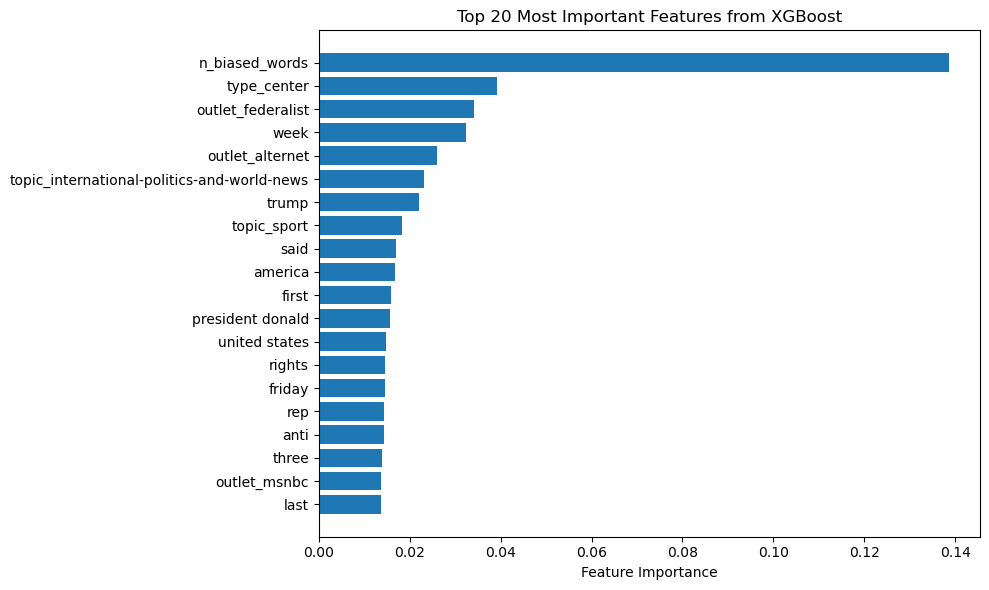

In [ ]:
# Plot top feature importance
top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(fi_df["feature"].head(top_n)[::-1], fi_df["importance"].head(top_n)[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important Features from XGBoost")
plt.tight_layout()
plt.show()
